**NOTE: This notebook is written for the Google Colab platform, which provides free hardware acceleration. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook, using a local GPU.**

In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install skorch

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p data/winequality
!wget -nc -O data/winequality.zip https://www.dropbox.com/s/8s0ivlo9yshhxkn/winequality.zip?dl=1
!unzip -oq -d data/winequality data/winequality.zip

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
def predefined_array_split(X_valid, Y_valid):
    return predefined_split(
        TensorDataset(
            torch.as_tensor(X_valid),
            torch.as_tensor(Y_valid)
        )
    )

# Classifying Wine Quality using Neural Nets

In this notebook you can try out a neural classifier on another simple dataset.

**Note:** The example is purely illustrational. The dataset is well-structured (the data is divided into columns with clear meanings etc.), and would therefore probably be approached with a different method in practice – possibly with some approached based on decision trees. Artificial neural networks and deep learning are usually applied to problems with unstructured data, such as images, audio, text etc.

## Loading and Preprocessing the Dataset

We will load the dataset from a CSV file:

In [ ]:
df = pd.read_csv("data/winequality/winequality-white.csv")
df.head()

The description of the data comes in a separate file, should we need it:

In [ ]:
with open("data/winequality/winequality", "r") as file:
    print("".join(file.readlines()))

### The Splitting of the Dataset

Next we continue by splitting the dataset. In this case, however, the data will not be split into two parts the way we usually split it, but rather into three parts: training, validation and testing data in the ratio of 70 : 5 : 25. The validation data will be used during learning for regularization and model selection (the details are below). When splitting, we stratify by quality.

In [ ]:
df_train_valid, df_test = train_test_split(df, test_size=0.25,
                                     stratify=df['quality'],
                                     random_state=4)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.05/0.75,
                                     stratify=df_train_valid['quality'],
                                     random_state=4)

### Column Selection and Pipeline Creation

As usual, we will determine which columns are numeric and which are categorical and we will create our pipeline object for preprocessing.

In [ ]:
categorical_inputs = []
numeric_inputs = list(df.columns[:-1])
output = ["quality"]

input_preproc = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy='constant', fill_value='MISSING'),
        OneHotEncoder()),
     categorical_inputs),
    
    (make_pipeline(
        SimpleImputer(),
        StandardScaler()),
     numeric_inputs)
)

Wine quality is given on a scale from 1 to 10 in our dataset (column ``quality``). Given that our dataset contains a relatively large amount of noise, this scale might be too fine: we will instead differentiate between three degrees of quality and we will do the transformation to the new scale automatically: using transformer ``KBinsDiscretizer`` from the ``scikit-learn`` package.

In [ ]:
output_preproc = KBinsDiscretizer(3, encode='ordinal', strategy='quantile')

### Application of Pre-processing

Finally, we apply our transformers to the data. As usual, we make sure to apply the ``transform`` method and not the ``fit_transform`` method to our testing – and in this case also to our validation – data.

In [ ]:
X_train = input_preproc.fit_transform(df_train[categorical_inputs+numeric_inputs])
Y_train = output_preproc.fit_transform(df_train[output]).reshape(-1)

X_valid = input_preproc.transform(df_valid[categorical_inputs+numeric_inputs])
Y_valid = output_preproc.transform(df_valid[output]).reshape(-1)

X_test = input_preproc.transform(df_test[categorical_inputs+numeric_inputs])
Y_test = output_preproc.transform(df_test[output]).reshape(-1)

We also convert into the datatypes expected by Pytorch, i.e. to 32-bit floats (inputs) and 64-bit integers (class labels).

In [ ]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.int64)
X_valid = X_valid.astype(np.float32)
Y_valid = Y_valid.astype(np.int64)
X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.int64)

---
## Task 1

**Apply a neural classifier to the wine quality classification problem.**

**Note: It may be useful to insert more layers and with a greater number of neurons than in the case of the IRIS dataset.**

---

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_inputs = X_train.shape[1]
num_outputs = len(np.unique(Y_train))

class Net(nn.Module):

    
    # ------





### Testing the Model on the Validation Set

Given that this is not the final version of our model (we will introduce other versions below), we will **not yet test the performance using the testing set** (we need to hold that out for the final testing in order to verify generalization), but rather using the **validation set**.

# Regularization

To prevent overfitting and improve generalization, it is good to use some regularization methods. The name regularization derives from the fact that we want our model to capture the real regularities in the data and not the noise. I.e. we want the model to generalize correctly. There is a number of approaches that can help. In this section of the notebook we will consider at least some of the very simple ones.

Some regularization methods will require data in order to tune the regularization parameters etc. We cannot use the testing data for this purpose – otherwise we would not be able to use them to verify generalization afterwards. This is why we have set apart the **validation set**. This separate set can be used throughout learning to estimate how well the model is going to generalize – but we still have a separate testing set which is not available to the model during training in any way.

## Early Stopping

The first regularization method that we are going to consider is early stopping. Early stopping means that we stop training as soon as the loss on the validation set stops decreasing – even if the loss on the training data continues to decrease. This is because in such case the network is not likely to generalize correctly and the performance on the training set is increasing because the model has started to memorize the samples.

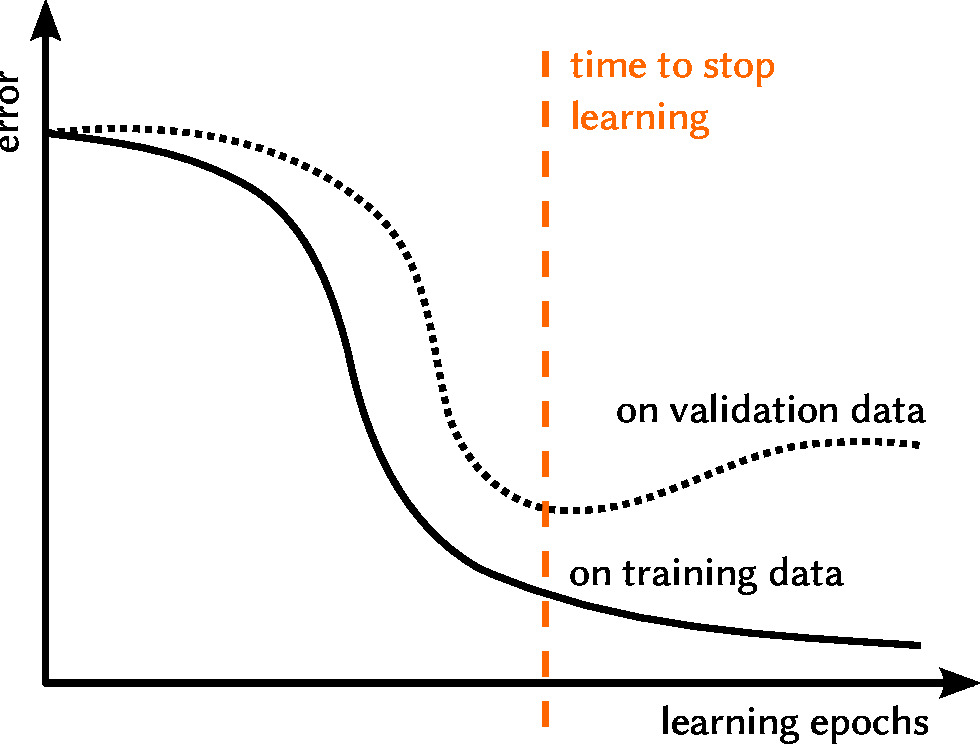

## Early Stopping Using the ``skorch`` package

In the ``skorch`` package early stopping can be achieved using the ``EarlyStopping`` class – by adding its instance among the classifier's **callbacks**. When creating the instance, we can specify a few parameters. The most important of these is:
* **``patience``:** specifies how many steps we wait once the validation loss stops decreasing before we stop learning.

Parameter ``patience`` is set to 5 by default. In some cases, especially when the validation set is very small, it may be better to use a slightly higher patience: we cannot be confident that the validation loss will not decrease further in the following epochs.

In order to evaluate the loss on validation data, we will of course need to specify the data. This can be done using the ``train_split`` argument to which we will assign our validation set using the auxiliary function ``predefined_array_split``.

In [ ]:
net = NeuralNetClassifier(
    Net,
    max_epochs=200,
    batch_size=-1,
    optimizer=torch.optim.Adam,
    train_split=predefined_array_split(X_valid, Y_valid),
    device=device,
    callbacks=[
        EarlyStopping(patience=10)
    ]
)

In [ ]:
net.fit(X_train, Y_train)

### Testing on the Validation Set

The resulting network will again be tested on the validation set. If we are lucky the results will be somewhat better than in the previous case. Of course, this cannot be guaranteed – it depends on all the hyperparameters and also on some random variables (such as those related to weight initialization).

In [ ]:
y_valid = net.predict(X_valid)

cm = pd.crosstab(
    output_preproc.inverse_transform(
        Y_valid.reshape(-1, 1)).reshape(-1),
    output_preproc.inverse_transform(
        y_valid.reshape(-1, 1)).reshape(-1),
    rownames=['actual'],
    colnames=['predicted']
)
print(cm)

acc = accuracy_score(Y_valid, y_valid)
print("Accuracy on valid = {}".format(acc))

## Dropout

With some neural architectures overfitting may occur so fast that early stopping will not be able to improve the results sufficiently. In such cases we might need other ways to decrease the capacity of the model and make it converge a little more gradually.

We can, for instance, use the ``nn.Dropout`` layer – in that case a portion of the neurons in the corresponding layer will be turned off randomly. The probability of turning off is one of the layer's parameters. Let us say that we want the probability of turning off the individual outputs of a particular layer to be 0.2. We could then add a dropout layer after it in the following way:
```python
class Net(nn.Module):
    def __init__(self):
        
        ...
        
        self.dropout = nn.Dropout(0.2)

        ...
        
    def forward(self, x):

        ...
        
        y = torch.relu(y)
        y = self.dropout(y)
        
        ...
        
```

We typically do not insert a dropout layer after the output layer (given that the outputs are read directly from the output layer, if its outputs are zeroes out, this will cause errors that no network – no matter how robust – would be able to prevent).

### Dropout and the Model's Capacity

Whenever we use more agressive forms of regularization, this may reduce the capacity of the model too significantly. When using many ``Dropout`` layers, it can therefore be necessary to make the model a bit larger than it would ordinarily be.

The interaction between various kinds of regularization can also be nontrivial: e.g. when using dropout, we can expect the validation loss to be a lot more noisy (new sources of stochasticity have been added); it can therefore be necessary to use significantly larger values of ``patience`` in such cases.

---

## Task 2

**Try to insert a few ``Dropout`` layers into your networks. E.g. one ``Dropout`` layer after each ``relu``.**

**When testing the effectiveness of your regularization only use the validation set. The testing set needs to be held out until the end – we can only use it once!**

---

### Testing on the Validation Set

We will again test on the validation set.

In [ ]:
y_valid = net.predict(X_valid)

cm = pd.crosstab(
    output_preproc.inverse_transform(
        Y_valid.reshape(-1, 1)).reshape(-1),
    output_preproc.inverse_transform(
        y_valid.reshape(-1, 1)).reshape(-1),
    rownames=['actual'],
    colnames=['predicted']
)
print(cm)

acc = accuracy_score(Y_valid, y_valid)
print("Accuracy on valid = {}".format(acc))

## Výsledky na testovacej množine

Once we have arrived at our final model, we will finally test its generalization on the testing data as well. Accuracy of around 75 – 77% will be a relatively good result on this dataset.

In [ ]:
y_test = net.predict(X_test)

cm = pd.crosstab(
    output_preproc.inverse_transform(
        Y_test.reshape(-1, 1)).reshape(-1),
    output_preproc.inverse_transform(
        y_test.reshape(-1, 1)).reshape(-1),
    rownames=['actual'],
    colnames=['predicted']
)
print(cm)

acc = accuracy_score(Y_test, y_test)
print("Accuracy on test = {}".format(acc))

## Classification Using Gradient-Boosted Decision Trees

To reinforce the point that neural nets do not bring many advantages when applied to structured data and that better results can usually be achieved by other methods, we will now compare our results with the ``LightGBM`` method, which is based on an ensemble of decision trees created using gradient boosting. There is a good chance that the results will be better than we could achieve using a neural net: and the learning will be significantly faster. The real advantages of neural networks will only become obvious once we start to apply them to more complex data such as image, audio, etc.

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
lgb.fit(X_train, Y_train)

y_test = lgb.predict(X_test)
cm = pd.crosstab(Y_test.reshape(-1),
                 y_test.reshape(-1),
                 rownames=['actual'],
                 colnames=['predicted'])
print(cm)

print("Accuracy on test: {}.".format(accuracy_score(
    Y_test, y_test
)))